In [1]:
import torch.nn as nn
import torch.nn.parallel
import random
import argparse
# from resnet import resnet18
# from network.pointnet import PointNetCls
from torch.utils.data import DataLoader
# from resnet import resent18 as net
import os
import numpy as np
from Models import FMNIST_classifier
from fmnist_prepare_subset_select_train_val_test import F_MNIST
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import torch.nn.functional as F
from termcolor import cprint
# from knn_utils import calc_knn_graph, calc_topo_weights_with_components_idx

from subset_select_ipot_non_uniform_pytorch_git import subset_select_ipot_pytorch as ss_ipot
from noise import noisify_with_P, noisify_cifar10_asymmetric, noisify_cifar100_asymmetric, noisify_pairflip, noisify_modelnet40_asymmetric
import copy
from scipy.stats import mode
from matplotlib import pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"


In [ ]:
# def _init_fn(worker_id):
#     np.random.seed(77 + worker_id)


# # models_path = "G:\\My Drive\\Research Codes\\Subset Selection Paper\\Neural Network Classifier\\models\\UCI-subset-select\\MNIST\\"
# models_path = ""

# train_val_ratio = 0.8
# # trust_prop = 0.5

# batch_size_train = 512

# num_classes = 10

# # noise_level = 0.8

# trust_props = [0.2, 0.4, 0.6, 0.8]
# noise_levels = [0.2, 0.4, 0.6, 0.8]

# for trust_prop in trust_props:
#     for noise_level in noise_levels:

#         print("trust_prop=", trust_prop)
#         print("noise_level=", noise_level)
#         torch.manual_seed(77)
#         random_seed = 42

#         transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
#         trainset = F_MNIST(root='./data', split='train', train_ratio=train_val_ratio,trust_prop=trust_prop,  download=True, transform=transform)
#         trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=0, worker_init_fn=_init_fn)


#         noise_y_train_labels0, noise_y_train_indices = trainset.get_noisy_labels_with_indices()
#         noise_y_train, p, _ = noisify_with_P(noise_y_train_labels0, nb_classes=num_classes, noise=noise_level, random_state=random_seed)
#         trainset.update_corrupted_label(noise_y_train, noise_y_train_indices)

#         valset = F_MNIST(root='./data', split='val', train_ratio=train_val_ratio, trust_prop=trust_prop, download=True, transform=transform)
#         valloader = torch.utils.data.DataLoader(valset, batch_size=512, shuffle=False, num_workers=0)

#         testset = F_MNIST(root='./data', split='test',download=True, transform=transform)
#         testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=0)

#         max_epochs = 100
#         unique_labels = [int(i) for i in list(np.linspace(0, 10, 10, endpoint=False))]
#         torch.manual_seed(0)

#         net = FMNIST_classifier().to(device)
#         criterion = nn.CrossEntropyLoss(reduction='mean')
#         optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)
#         milestones = [25, 50, 75]
#         lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.5, last_epoch=- 1, verbose=False)

#         train_acc = []
#         val_acc = []
#         best_accuracy = 0

#         for epoch in range(max_epochs):  # loop over the dataset multiple times
#             running_loss = []
#             for i, data in enumerate(trainloader, 0):
#                 # get the inputs; data is a list of [inputs, labels]
#                 # _, images, labels, _, _ = data
#                 images, labels, _, _, _ = data
#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward + backward + optimize
#                 outputs, _ = net(images.to(device))
#                 loss = criterion(outputs, labels.long().to(device))
#                 loss.backward()
#                 optimizer.step()

#                 running_loss.append(loss.item())
#                 # avg_loss.append(torch.tensor(running_loss).mean())
#             print("epoch={0:d},  avg_loss = {1:0.4f}".format(
#                 epoch, torch.tensor(running_loss).mean()))

#             if True:
#                 classes = tuple([str(i) for i in unique_labels])
#                 correct_pred = {classname: 0 for classname in classes}
#                 total_pred = {classname: 0 for classname in classes}
#                 total = 0
#                 correct = 0

#                 net.eval()
#                 with torch.no_grad():
#                     for data in valloader:
#                         images, labels, _, _, _ = data
#                         outputs, _ = net(images.to(device))
#                         _, predictions = torch.max(outputs, dim=1)
#                         total += labels.size(0)
#                         correct += (predictions.cpu() == labels).sum().item()
#                     print(f'val set accuraccy: {100 * correct / total} %')
#                     val_acc.append(100 * correct / total)

#                 if val_acc[-1] > best_accuracy:
#                     best_accuracy = val_acc[-1]
#                     net_path = models_path + "FMNIST_noisy"+"trust_prop={trust_prop:0.2f}".format(
#                         trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
#                     torch.save({
#                         'epoch': epoch,
#                         'model_state_dict': net.state_dict(),
#                         'optimizer_state_dict': optimizer.state_dict(),
#                         'val-accuracy': val_acc,
#                         'train-accuracy': train_acc}, net_path)

#                 classes = tuple([str(i) for i in unique_labels])
#                 correct_pred = {classname: 0 for classname in classes}
#                 total_pred = {classname: 0 for classname in classes}
#                 total = 0
#                 correct = 0
#                 net.eval()
#                 with torch.no_grad():
#                     for data in trainloader:
#                         images, labels, _, _, _ = data
#                         outputs, _ = net(images.to(device))
#                         _, predictions = torch.max(outputs, dim=1)
#                         total += labels.size(0)
#                         correct += (predictions.cpu() == labels).sum().item()
#                 print(f'train set accuracy: {100 * correct / total} %')
#                 train_acc.append(100 * correct / total)

#         print('Finished Training')
#         # saving training accuracy list along with model with best accuracy
#         net_path = models_path + "FMNIST_noisy"+"trust_prop={trust_prop:0.2f}".format(
#             trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
#         best_net_dict = torch.load(net_path)
#         best_net_dict['val-accuracy'] = val_acc
#         best_net_dict['train-accuracy'] = train_acc
#         torch.save(best_net_dict, net_path)


test set accuraccy: 89.8 %
test set accuraccy: 88.74 %
test set accuraccy: 87.39 %
test set accuraccy: 84.93 %
test set accuraccy: 89.4 %
test set accuraccy: 89.34 %
test set accuraccy: 88.03 %
test set accuraccy: 87.34 %
test set accuraccy: 90.37 %
test set accuraccy: 89.59 %
test set accuraccy: 89.18 %
test set accuraccy: 88.45 %
test set accuraccy: 90.12 %
test set accuraccy: 89.65 %
test set accuraccy: 89.7 %
test set accuraccy: 89.06 %


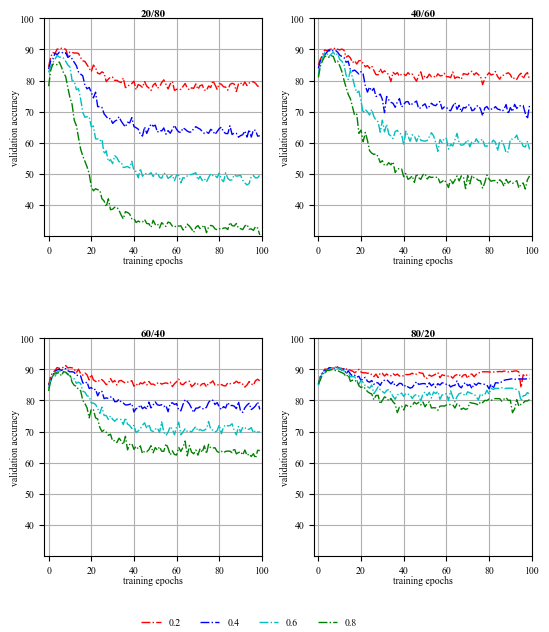

In [7]:
import pandas as pd
import matplotlib
font = {'family': 'Times New Roman',
        'size'   : 7}
font1 = {'family': 'Times New Roman',
        'size'   : 7}

matplotlib.rc('font', **font)

trust_props = [0.2, 0.4, 0.6, 0.8]
noise_levels = [0.2, 0.4, 0.6, 0.8]
max_epochs = 100
fig, axs = plt.subplots(2, 2, figsize=(5.5, 6.6), tight_layout=True)

max_val_accs = np.zeros([len(trust_props), len(noise_levels)])
max_test_accs = np.zeros([len(trust_props), len(noise_levels)])

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

testset = F_MNIST(root='./data', split='test',download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=0)
unique_labels = [0,1,2,3,4,5,6,7,8,9]

# G: \My Drive\Research Codes\Subset Selection Paper\Neural Network Classifier\USPS\CIFAR10\test on noisy data\Lambda tests\ss_1 cifar10 c = 20trust_prop = 0.40noise_level = 0.20.pth

models_path = ""

line_colors = ['r', 'b', 'c', 'g']
for i in range(len(trust_props)):
    for j in range(len(noise_levels)):
        trust_prop = trust_props[i]
        noise_level = noise_levels[j]
        net_path = models_path + "FMNIST_noisy"+"trust_prop={trust_prop:0.2f}".format(trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
        best_net_dict = torch.load(net_path)
        net = FMNIST_classifier().to(device)
        net.load_state_dict(best_net_dict['model_state_dict'])
        
        classes = tuple([str(i) for i in unique_labels])
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}
        total = 0
        correct = 0

        net.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels, _, _, _ = data
                outputs, _ = net(images.to(device))
                _, predictions = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predictions.cpu() == labels).sum().item()
            print(f'test set accuraccy: {100 * correct / total} %')
        max_test_accs[i, j] = 100 * correct / total
        
        
        acc_ci = best_net_dict["val-accuracy"]
        max_val_accs[i,j] = max(acc_ci)
        acc_ci = np.array([i/100 for i in acc_ci])
        iters = np.linspace(0, max_epochs, 100, endpoint=False)
        # label_str = "{trust_prop:0.0f}%".format(trust_prop=int(100*trust_prop)) + " {noise_level:0.1f}".format(noise_level=noise_level)
        label_str = "{noise_level:0.1f}".format(noise_level=noise_level)
        if i != len(trust_props)-1:
            axs.flatten()[i].plot(iters, 100*acc_ci, color = line_colors[j], linestyle="-.", linewidth=1.0)
        else:
            axs.flatten()[i].plot(iters, 100*acc_ci, color=line_colors[j], linestyle="-.", label=label_str, linewidth=1.0)
            
    title_str = str(int(100*trust_prop)) + "/" + str(int(100 - 100*trust_prop))
    axs.flatten()[i].set_title(title_str, font = {'weight' : 'bold', 'size':8}, pad = 0)
    axs.flatten()[i].set_xlabel("training epochs", labelpad=0.01, **font)
    axs.flatten()[i].set_ylabel("validation accuracy", labelpad=0.01, **font)
    axs.flatten()[i].set_xlim([-2,100])
    axs.flatten()[i].set_yticks([40,50,60,70,80,90,100])
    axs.flatten()[i].set_ylim([30,100])
    axs.flatten()[i].grid()
    axs.flatten()[i].set_box_aspect(1)
    # axs.flatten()[i].legend(ncol=1, prop =font1)
fig.legend(loc = (0.25,0.001), prop =font1, ncol=4, frameon=False)
# fig.tight_layout()
max_val_accs_df = pd.DataFrame(max_val_accs, index = [int(100*i) for i in trust_props], columns = noise_levels)
max_test_accs_df = pd.DataFrame(max_test_accs, index = [int(100*i) for i in trust_props], columns = noise_levels)


In [8]:
max_val_accs_df

,0.2,0.4,0.6,0.8
20,90.375000,89.158333,88.091667,85.966667
40,90.491667,89.725000,89.116667,87.983333
60,91.233333,90.266667,89.516667,89.258333
80,90.816667,90.758333,90.525000,89.958333


In [9]:
max_test_accs_df


,0.2,0.4,0.6,0.8
20,89.80,88.74,87.39,84.93
40,89.40,89.34,88.03,87.34
60,90.37,89.59,89.18,88.45
80,90.12,89.65,89.70,89.06


In [ ]:
# def _init_fn(worker_id):
#     np.random.seed(77 + worker_id)


# # models_path = "G:\\My Drive\\Research Codes\\Subset Selection Paper\\Neural Network Classifier\\models\\UCI-subset-select\\MNIST\\"
# models_path = ""

# train_val_ratio = 0.8
# batch_size_train = 512
# num_classes = 10
# noise_level = 0.8
# cs = [2, 20]
# # c = 20
# max_epochs = 100
# gamma_ss = 0.01

# trust_props = [0.2, 0.4, 0.6, 0.8]
# noise_levels = [0.2, 0.4, 0.6, 0.8]

# # models_path + "ss_1 " +  "cifar10 " + "c={cs:2d}".format(cs=c)+".pth"
# for c in cs:
#     for trust_prop in trust_props:
#         for noise_level in noise_levels:

#             print("trust_prop=", trust_prop)
#             print("noise_level=", noise_level)

#             torch.manual_seed(42)

#             transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
#             trainset = F_MNIST(root='./data', split='train', train_ratio=train_val_ratio,trust_prop=trust_prop,  download=True, transform=transform)
#             trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=0, worker_init_fn=_init_fn)


#             noise_y_train_labels0, noise_y_train_indices = trainset.get_noisy_labels_with_indices()
#             noise_y_train, p, _ = noisify_with_P(noise_y_train_labels0, nb_classes=num_classes, noise=noise_level, random_state=random_seed)
#             trainset.update_corrupted_label(noise_y_train, noise_y_train_indices)

#             valset = F_MNIST(root='./data', split='val', train_ratio=train_val_ratio, trust_prop=trust_prop, download=True, transform=transform)
#             valloader = torch.utils.data.DataLoader(valset, batch_size=512, shuffle=False, num_workers=0)

#             testset = F_MNIST(root='./data', split='test',download=True, transform=transform)
#             testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=0)

#             max_epochs = 100
#             unique_labels = [int(i) for i in list(np.linspace(0, 10, 10, endpoint=False))]
#             torch.manual_seed(0)

#             net = FMNIST_classifier().to(device)
#             criterion = nn.CrossEntropyLoss(reduction='mean')
#             optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)
#             milestones = [25, 50, 75]
#             lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.5, last_epoch=- 1, verbose=False)

#             train_acc = []
#             val_acc = []
#             best_accuracy = 0

#             for epoch in range(max_epochs):  # loop over the dataset multiple times
#                 running_loss = []
#                 for i, data in enumerate(trainloader, 0):
#                     # get the inputs; data is a list of [inputs, labels]
#                     # _, images, labels, _, _ = data
#                     images, labels, weights, cd_y, idx = data
#                     # zero the parameter gradients
#                     optimizer.zero_grad()

#                     # forward + backward + optimize
#                     outputs, encodings = net(images.to(device))


#                     x = encodings[cd_y == 1].detach()
#                     y = encodings[cd_y == 0].detach()
#                     x_labels = labels[cd_y == 1].detach()
#                     y_labels = labels[cd_y == 0].detach()
#                     x_idx = idx[cd_y == 1].detach()
#                     y_idx = idx[cd_y == 0].detach()

#                     x_labels_onehot = (F.one_hot(x_labels.long(), num_classes=num_classes)).to(device).float()

#                     mu = (1/x.shape[0]*torch.ones(x.shape[0])).to(device)
#                     nu = (1/y.shape[0]*torch.ones(y.shape[0])).to(device)
#                     costs, P, _, _ = ss_ipot(x, y, mu, nu, c,  gamma_ss, max_outer_iter=20,max_inner_iter=20, wd=2, disp_iter=False, return_map=True)

#                     # P_torch = torch.from_numpy(P).to(device)
#                     P_torch = P.clone()
#                     y_labels_hat = (P_torch.T@x_labels_onehot).to(device)

#                     input_labels_hat = torch.zeros_like(outputs, device=device, dtype=torch.double)
#                     input_labels_hat[cd_y == 1] = 1 / x.shape[0] * (x_labels_onehot.double())
#                     input_labels_hat[cd_y == 0] = y_labels_hat.double()

#                     loss = - torch.sum(input_labels_hat*F.log_softmax(outputs, dim=1))
#                     loss.backward()
#                     optimizer.step()
#                     running_loss.append(loss.item())
#                     # avg_loss.append(torch.tensor(running_loss).mean())
#                 print("epoch={0:d},  avg_loss = {1:0.4f}".format(
#                     epoch, torch.tensor(running_loss).mean()))

#                 if True:
#                     classes = tuple([str(i) for i in unique_labels])
#                     correct_pred = {classname: 0 for classname in classes}
#                     total_pred = {classname: 0 for classname in classes}
#                     total = 0
#                     correct = 0

#                     net.eval()
#                     with torch.no_grad():
#                         for data in valloader:
#                             images, labels, _, _, _ = data
#                             outputs, _ = net(images.to(device))
#                             _, predictions = torch.max(outputs, dim=1)
#                             total += labels.size(0)
#                             correct += (predictions.cpu() == labels).sum().item()
#                         print(f'val set accuraccy: {100 * correct / total} %')
#                         val_acc.append(100 * correct / total)

#                     if val_acc[-1] > best_accuracy:
#                         best_accuracy = val_acc[-1]
#                         net_path = models_path + "ss_1 " +  "fmnist " + "c={cs:2d}".format(cs=c)+"trust_prop={trust_prop:0.2f}".format(trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
#                         torch.save({
#                             'epoch': epoch,
#                             'model_state_dict': net.state_dict(),
#                             'optimizer_state_dict': optimizer.state_dict(),
#                             'val-accuracy': val_acc,
#                             'train-accuracy': train_acc}, net_path)

#                     classes = tuple([str(i) for i in unique_labels])
#                     correct_pred = {classname: 0 for classname in classes}
#                     total_pred = {classname: 0 for classname in classes}
#                     total = 0
#                     correct = 0
#                     net.eval()
#                     with torch.no_grad():
#                         for data in trainloader:
#                             images, labels, _, _, _ = data
#                             outputs, _ = net(images.to(device))
#                             _, predictions = torch.max(outputs, dim=1)
#                             total += labels.size(0)
#                             correct += (predictions.cpu() == labels).sum().item()
#                     print(f'train set accuracy: {100 * correct / total} %')
#                     train_acc.append(100 * correct / total)


#             print('Finished Training')
#             # saving training accuracy list along with model with best accuracy
#             net_path = models_path + "ss_1 " + "fmnist " + "c={cs:2d}".format(cs=c)+"trust_prop={trust_prop:0.2f}".format(
#                 trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
#             best_net_dict = torch.load(net_path)
#             best_net_dict['val-accuracy'] = val_acc
#             best_net_dict['train-accuracy'] = train_acc
#             torch.save(best_net_dict, net_path)


test set accuraccy: 88.49 %
test set accuraccy: 88.13 %
test set accuraccy: 88.22 %
test set accuraccy: 88.42 %
test set accuraccy: 88.68 %
test set accuraccy: 89.16 %
test set accuraccy: 89.48 %
test set accuraccy: 89.36 %
test set accuraccy: 90.0 %
test set accuraccy: 90.06 %
test set accuraccy: 89.37 %
test set accuraccy: 90.15 %
test set accuraccy: 89.95 %
test set accuraccy: 89.7 %
test set accuraccy: 90.04 %
test set accuraccy: 90.33 %


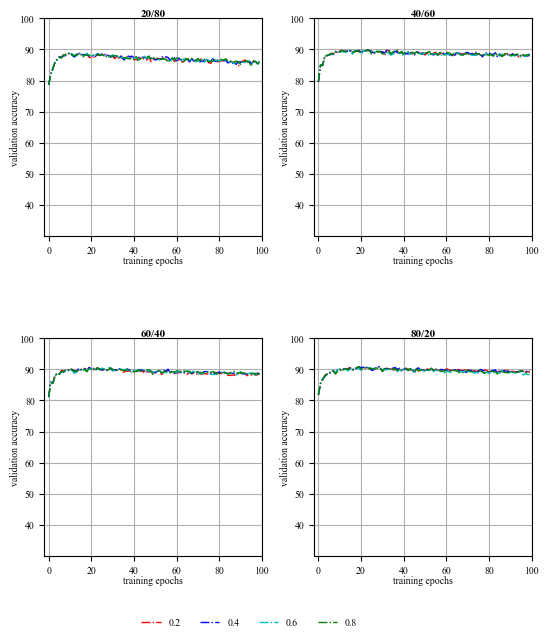

In [10]:
import pandas as pd
import matplotlib
font = {'family': 'Times New Roman',
        'size'   : 7}
font1 = {'family': 'Times New Roman',
        'size'   : 7}

matplotlib.rc('font', **font)

trust_props = [0.2, 0.4, 0.6, 0.8]
noise_levels = [0.2, 0.4, 0.6, 0.8]
max_epochs = 100
fig, axs = plt.subplots(2, 2, figsize=(5.5, 6.6), tight_layout=True)

c = 2
max_val_accs = np.zeros([len(trust_props), len(noise_levels)])
max_test_accs = np.zeros([len(trust_props), len(noise_levels)])

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

testset = F_MNIST(root='./data', split='test',download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=0)
unique_labels = [0,1,2,3,4,5,6,7,8,9]

# G: \My Drive\Research Codes\Subset Selection Paper\Neural Network Classifier\USPS\CIFAR10\test on noisy data\Lambda tests\ss_1 cifar10 c = 20trust_prop = 0.40noise_level = 0.20.pth

models_path = ""

line_colors = ['r', 'b', 'c', 'g']
for i in range(len(trust_props)):
    for j in range(len(noise_levels)):
        trust_prop = trust_props[i]
        noise_level = noise_levels[j]
        net_path = models_path + "ss_1 " + "fmnist " + "c={cs:2d}".format(cs=c)+"trust_prop={trust_prop:0.2f}".format(
            trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
        best_net_dict = torch.load(net_path)
        net = FMNIST_classifier().to(device)
        net.load_state_dict(best_net_dict['model_state_dict'])
        
        classes = tuple([str(i) for i in unique_labels])
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}
        total = 0
        correct = 0

        net.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels, _, _, _ = data
                outputs, _ = net(images.to(device))
                _, predictions = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predictions.cpu() == labels).sum().item()
            print(f'test set accuraccy: {100 * correct / total} %')
        max_test_accs[i, j] = 100 * correct / total
        
        
        acc_ci = best_net_dict["val-accuracy"]
        max_val_accs[i,j] = max(acc_ci)
        acc_ci = np.array([i/100 for i in acc_ci])
        iters = np.linspace(0, max_epochs, 100, endpoint=False)
        # label_str = "{trust_prop:0.0f}%".format(trust_prop=int(100*trust_prop)) + " {noise_level:0.1f}".format(noise_level=noise_level)
        label_str = "{noise_level:0.1f}".format(noise_level=noise_level)
        if i != len(trust_props)-1:
            axs.flatten()[i].plot(iters, 100*acc_ci, color = line_colors[j], linestyle="-.", linewidth=1.0)
        else:
            axs.flatten()[i].plot(iters, 100*acc_ci, color=line_colors[j], linestyle="-.", label=label_str, linewidth=1.0)
            
    title_str = str(int(100*trust_prop)) + "/" + str(int(100 - 100*trust_prop))
    axs.flatten()[i].set_title(title_str, font = {'weight' : 'bold', 'size':8}, pad = 0)
    axs.flatten()[i].set_xlabel("training epochs", labelpad=0.01, **font)
    axs.flatten()[i].set_ylabel("validation accuracy", labelpad=0.01, **font)
    axs.flatten()[i].set_xlim([-2,100])
    axs.flatten()[i].set_yticks([40,50,60,70,80,90,100])
    axs.flatten()[i].set_ylim([30,100])
    axs.flatten()[i].grid()
    axs.flatten()[i].set_box_aspect(1)
    # axs.flatten()[i].legend(ncol=1, prop =font1)
fig.legend(loc = (0.25,0.001), prop =font1, ncol=4, frameon=False)
# fig.tight_layout()
max_val_accs_df = pd.DataFrame(max_val_accs, index = [int(100*i) for i in trust_props], columns = noise_levels)
max_test_accs_df = pd.DataFrame(max_test_accs, index = [int(100*i) for i in trust_props], columns = noise_levels)


In [11]:
max_val_accs_df

,0.2,0.4,0.6,0.8
20,88.958333,88.941667,89.058333,88.950000
40,89.758333,89.883333,89.658333,89.783333
60,90.550000,90.616667,90.466667,90.550000
80,90.833333,90.975000,90.741667,90.858333


In [12]:
max_test_accs_df

,0.2,0.4,0.6,0.8
20,88.49,88.13,88.22,88.42
40,88.68,89.16,89.48,89.36
60,90.00,90.06,89.37,90.15
80,89.95,89.70,90.04,90.33


test set accuraccy: 88.17 %
test set accuraccy: 88.08 %
test set accuraccy: 87.76 %
test set accuraccy: 87.72 %
test set accuraccy: 88.86 %
test set accuraccy: 89.91 %
test set accuraccy: 89.27 %
test set accuraccy: 89.15 %
test set accuraccy: 90.07 %
test set accuraccy: 89.87 %
test set accuraccy: 89.85 %
test set accuraccy: 89.77 %
test set accuraccy: 90.29 %
test set accuraccy: 90.02 %
test set accuraccy: 90.32 %
test set accuraccy: 90.24 %


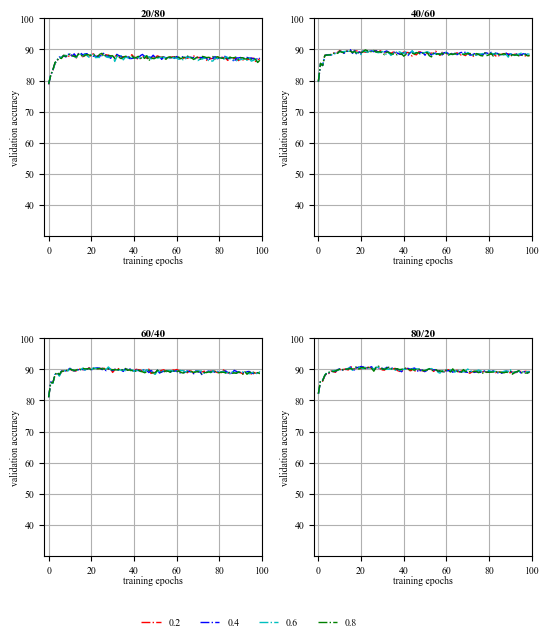

In [13]:
import pandas as pd
import matplotlib
font = {'family': 'Times New Roman',
        'size'   : 7}
font1 = {'family': 'Times New Roman',
        'size'   : 7}

matplotlib.rc('font', **font)

trust_props = [0.2, 0.4, 0.6, 0.8]
noise_levels = [0.2, 0.4, 0.6, 0.8]
max_epochs = 100
fig, axs = plt.subplots(2, 2, figsize=(5.5, 6.6), tight_layout=True)

c = 20
max_val_accs = np.zeros([len(trust_props), len(noise_levels)])
max_test_accs = np.zeros([len(trust_props), len(noise_levels)])

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

testset = F_MNIST(root='./data', split='test',download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=0)
unique_labels = [0,1,2,3,4,5,6,7,8,9]

# G: \My Drive\Research Codes\Subset Selection Paper\Neural Network Classifier\USPS\CIFAR10\test on noisy data\Lambda tests\ss_1 cifar10 c = 20trust_prop = 0.40noise_level = 0.20.pth

models_path = ""

line_colors = ['r', 'b', 'c', 'g']
for i in range(len(trust_props)):
    for j in range(len(noise_levels)):
        trust_prop = trust_props[i]
        noise_level = noise_levels[j]
        net_path = models_path + "ss_1 " + "fmnist " + "c={cs:2d}".format(cs=c)+"trust_prop={trust_prop:0.2f}".format(
            trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
        best_net_dict = torch.load(net_path)
        net = FMNIST_classifier().to(device)
        net.load_state_dict(best_net_dict['model_state_dict'])
        
        classes = tuple([str(i) for i in unique_labels])
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}
        total = 0
        correct = 0

        net.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels, _, _, _ = data
                outputs, _ = net(images.to(device))
                _, predictions = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predictions.cpu() == labels).sum().item()
            print(f'test set accuraccy: {100 * correct / total} %')
        max_test_accs[i, j] = 100 * correct / total
        
        
        acc_ci = best_net_dict["val-accuracy"]
        max_val_accs[i,j] = max(acc_ci)
        acc_ci = np.array([i/100 for i in acc_ci])
        iters = np.linspace(0, max_epochs, 100, endpoint=False)
        # label_str = "{trust_prop:0.0f}%".format(trust_prop=int(100*trust_prop)) + " {noise_level:0.1f}".format(noise_level=noise_level)
        label_str = "{noise_level:0.1f}".format(noise_level=noise_level)
        if i != len(trust_props)-1:
            axs.flatten()[i].plot(iters, 100*acc_ci, color = line_colors[j], linestyle="-.", linewidth=1.0)
        else:
            axs.flatten()[i].plot(iters, 100*acc_ci, color=line_colors[j], linestyle="-.", label=label_str, linewidth=1.0)
            
    title_str = str(int(100*trust_prop)) + "/" + str(int(100 - 100*trust_prop))
    axs.flatten()[i].set_title(title_str, font = {'weight' : 'bold', 'size':8}, pad = 0)
    axs.flatten()[i].set_xlabel("training epochs", labelpad=0.01, **font)
    axs.flatten()[i].set_ylabel("validation accuracy", labelpad=0.01, **font)
    axs.flatten()[i].set_xlim([-2,100])
    axs.flatten()[i].set_yticks([40,50,60,70,80,90,100])
    axs.flatten()[i].set_ylim([30,100])
    axs.flatten()[i].grid()
    axs.flatten()[i].set_box_aspect(1)
    # axs.flatten()[i].legend(ncol=1, prop =font1)
fig.legend(loc = (0.25,0.001), prop =font1, ncol=4, frameon=False)
# fig.tight_layout()
max_val_accs_df = pd.DataFrame(max_val_accs, index = [int(100*i) for i in trust_props], columns = noise_levels)
max_test_accs_df = pd.DataFrame(max_test_accs, index = [int(100*i) for i in trust_props], columns = noise_levels)


In [14]:
max_val_accs_df

,0.2,0.4,0.6,0.8
20,88.691667,88.891667,88.700000,88.750000
40,89.650000,89.916667,89.658333,89.858333
60,90.525000,90.475000,90.766667,90.400000
80,90.983333,90.941667,90.775000,91.041667


In [15]:
max_test_accs_df

,0.2,0.4,0.6,0.8
20,88.17,88.08,87.76,87.72
40,88.86,89.91,89.27,89.15
60,90.07,89.87,89.85,89.77
80,90.29,90.02,90.32,90.24
